Found 5216 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


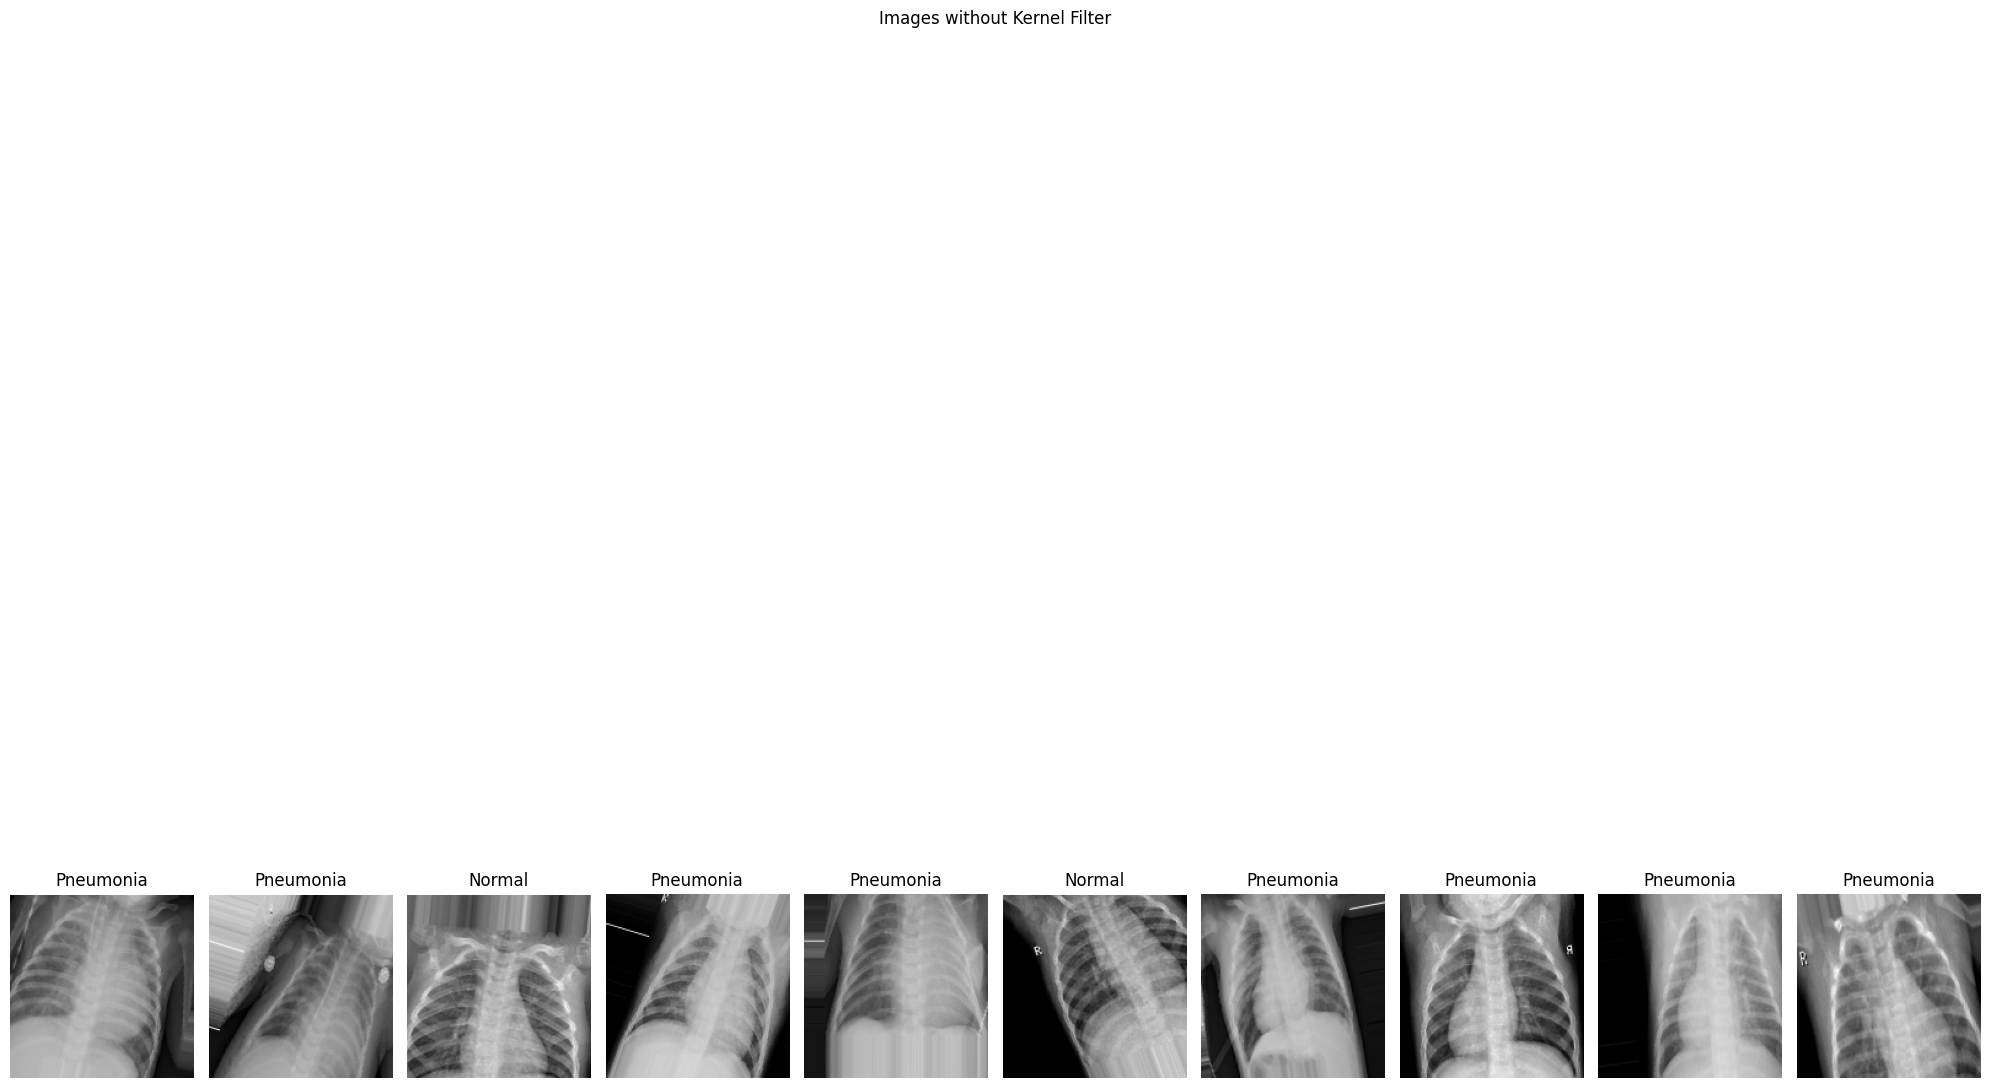

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

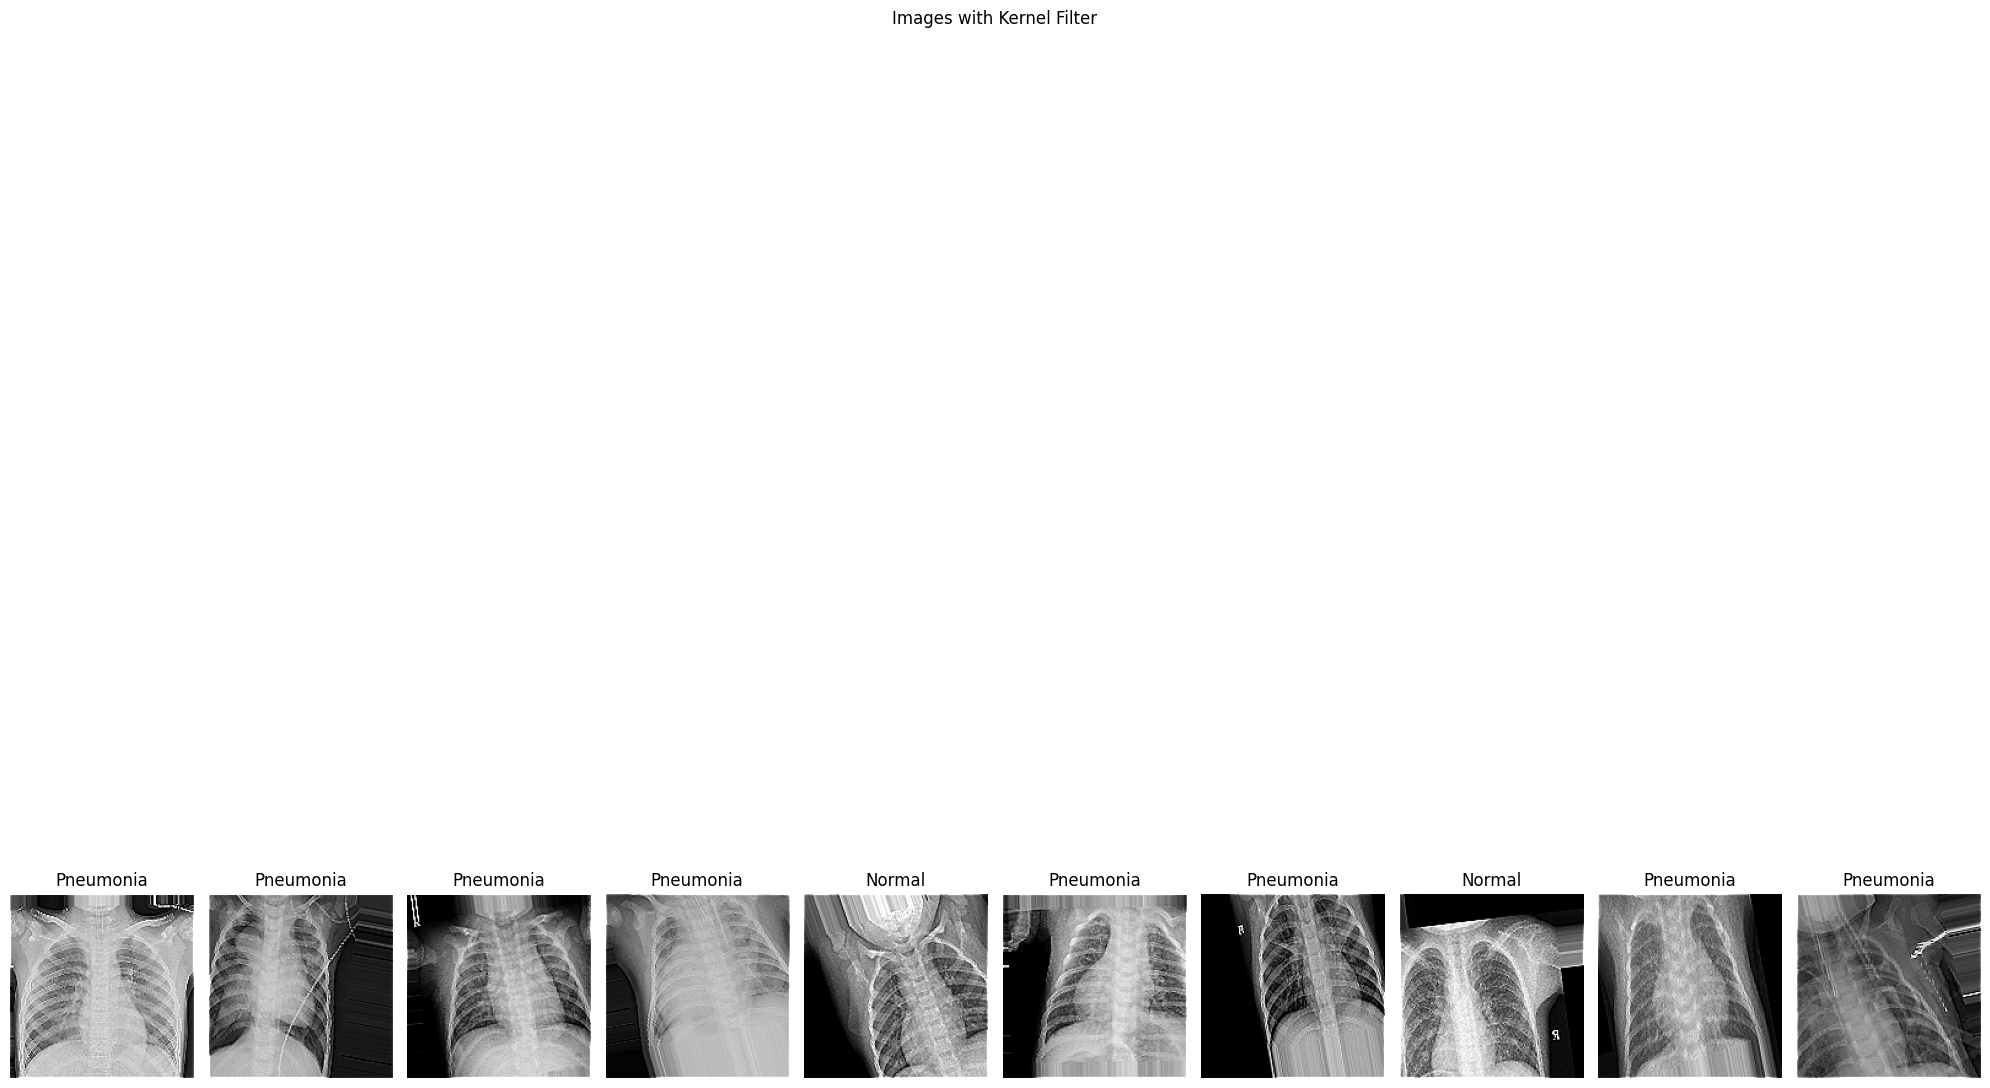

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define paths
base_dir = '/Users/hnguyen/Downloads/chest_xray' 
train_dir = f'{base_dir}/train'
validation_dir = f'{base_dir}/val'
test_dir = f'{base_dir}/test'

# Define a custom preprocessing function for kernel filters
def apply_kernel_filter(image):
    kernel = np.array([
        [0, -1, 0],
        [-1, 5, -1],
        [0, -1, 0]
    ], dtype=np.float32)
    kernel = np.stack([kernel] * 3, axis=-1)
    kernel = np.expand_dims(kernel, axis=-1)
    
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.expand_dims(image, axis=0)  # Add batch dimension
    image = tf.nn.depthwise_conv2d(image, kernel, strides=[1, 1, 1, 1], padding='SAME')
    image = tf.squeeze(image, axis=0)  # Remove batch dimension
    return image

# Create ImageDataGenerators for normalization and augmentation
train_datagen_no_filter = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_datagen_with_filter = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=apply_kernel_filter  # Apply kernel filter during augmentation
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Validation data shouldn't be augmented

# Load images from directories
train_generator_no_filter = train_datagen_no_filter.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

train_generator_with_filter = train_datagen_with_filter.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

# Function to plot images
def plot_images(images, labels, title):
    fig, axes = plt.subplots(1, 10, figsize=(20, 20))
    axes = axes.flatten()
    for img, label, ax in zip(images, labels, axes):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title('Normal' if label == 0 else 'Pneumonia')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Plot images before applying kernel filters
images_no_filter, labels_no_filter = next(train_generator_no_filter)
plot_images(images_no_filter, labels_no_filter, 'Images without Kernel Filter')

# Plot images after applying kernel filters
images_with_filter, labels_with_filter = next(train_generator_with_filter)
plot_images(images_with_filter, labels_with_filter, 'Images with Kernel Filter')

Epoch 1/10
260/260 [==============================] - 50s 191ms/step - loss: 0.4724 - accuracy: 0.7723 - val_loss: 0.8644 - val_accuracy: 0.5000
Epoch 2/10
260/260 [==============================] - 51s 196ms/step - loss: 0.3224 - accuracy: 0.8514 - val_loss: 1.1377 - val_accuracy: 0.6875
Epoch 3/10
260/260 [==============================] - 52s 199ms/step - loss: 0.2899 - accuracy: 0.8739 - val_loss: 0.6371 - val_accuracy: 0.8125
Epoch 4/10
260/260 [==============================] - 52s 200ms/step - loss: 0.2481 - accuracy: 0.8847 - val_loss: 0.3951 - val_accuracy: 0.8125
Epoch 5/10
260/260 [==============================] - 52s 198ms/step - loss: 0.2440 - accuracy: 0.8924 - val_loss: 0.4926 - val_accuracy: 0.8125
Epoch 6/10
260/260 [==============================] - 52s 198ms/step - loss: 0.2399 - accuracy: 0.8984 - val_loss: 0.4488 - val_accuracy: 0.8125
Epoch 7/10
260/260 [==============================] - 51s 197ms/step - loss: 0.2139 - accuracy: 0.9111 - val_loss: 0.5168 - val_ac

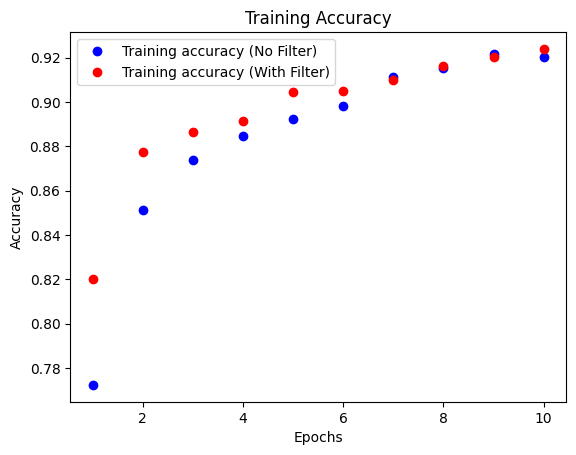

In [4]:
# Define CNN model for image classification
def build_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Calculate steps_per_epoch and validation_steps ensuring they are at least 1
steps_per_epoch_no_filter = max(train_generator_no_filter.samples // train_generator_no_filter.batch_size, 1)
validation_steps = max(validation_generator.samples // validation_generator.batch_size, 1)

steps_per_epoch_with_filter = max(train_generator_with_filter.samples // train_generator_with_filter.batch_size, 1)

# Train and evaluate the model without kernel filters
model_no_filter = build_model()
history_no_filter = model_no_filter.fit(
    train_generator_no_filter,
    steps_per_epoch=steps_per_epoch_no_filter,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_steps
)

# Train and evaluate the model with kernel filters
model_with_filter = build_model()
history_with_filter = model_with_filter.fit(
    train_generator_with_filter,
    steps_per_epoch=steps_per_epoch_with_filter,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_steps
)

# Plot the training accuracy of both models
def plot_training_accuracy(history_no_filter, history_with_filter):
    epochs = range(1, len(history_no_filter.history['accuracy']) + 1)
    
    plt.plot(epochs, history_no_filter.history['accuracy'], 'bo', label='Training accuracy (No Filter)', linestyle='None')
    plt.plot(epochs, history_with_filter.history['accuracy'], 'ro', label='Training accuracy (With Filter)', linestyle='None')
    
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_training_accuracy(history_no_filter, history_with_filter)